# 12 - Doubly Robust Estimation

## 한 우물만 파지마라

앞서 선형회귀와 경향 점수(propensity score)로 가중치 방식을 통해 $E[Y|T=1] - E[Y|T=0] | X$ 를 추정하는 방법을 배웠습니다. 그렇다면 언제, 어떤 것을 써야할까요? 고민된다면 둘 다 쓰세요! Doubly Robust Estimation (이중강건추정) 방법은 어느 둘 중 하나에 의존할 필요가 없도록 경향 점수와 선형회귀방법을 결합했습니다.

사고방식 실험을 통해 어떻게 작동하는지 알아봅시다. 사고방식 실험은 미국 고등학교 학생들을 무작위 추출하여 성장 사고방식의 효과를 알아보기 위한 연구입니다. 실험에서 학생들은 성장 사고방식을 심어주는 세미나에 초청됩니다. 그리고 학생들의 대학재학 기간 학업 능력을 추적하여 점수로 매깁니다. 이 점수는 성취점수로 취합되여 표준화됩니다. 이 실험의 실제 데이터는 학생들의 개인정보이므로 공개되지 않습니다. 대신 [Athey and Wager](https://arxiv.org/pdf/1902.07409.pdf)에서 제공한 실제 데이터와 똑같은 통계 요약치를 가지는 모의실험 데이터를 가지고 진행하겠습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


실험이 무작위적으로 진행됐지만 교란 변수 (confounding)이 없는 사례처럼은 보이지 않습니다. 한 가지 이유는 처치 변수 (treatment)가 학생들의 세미나 초청권 수령이기 때문입니다. 그래서 참여햘 기회는 무작위이지만 참석 자체는 그렇지 않습니다(초청 받았지만 참석하지 않는 사례들도 곧 다뤄보도록 하겠습니다). 그 증거로 학생들의 성공 기대감과 세미나 참석이 연관성 들 수 있습니다. 높은 기대치를 스스로 되새기는 학생들이 성장 사고방식 세미나에 참석했을 확률이 높을 것 같습니다. 

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

우리가 알고 있는 것을 토대로 우리는 이것을 해결하기 위해 선형회귀방법이나 로지스틱 회귀분석을 통한 경향 점수 추정을 적용할 수 있습니다. 하기 전에 범주형 변수들을 더미 (dummy) 처리해야합니다.  

In [4]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


이제 doubly robust estimation을 어떻게 작동하는지 이해할 준비가 됐습니다. 

## Doubly Robust Estimation

![img](./data/img/doubly-robust/double.png)

추정값을 바로 유도하기보단 먼저 이게 얼마나 멋진지 먼저 보여드리겠습니다.

$
\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)
$

여기서 $\hat{P}(x)$는 경향 점수(예를 들면, 로지스틱 회귀분석을 사용해서 얻은 점수)입니다. $\hat{\mu_1}(x)$은 $E[Y|X, T=1]$ 추정치(예를 들면, 선형 회귀분석으로 얻은 예측값)이고 그리고 $\hat{\mu_0}(x)$은 $E[Y|X, T=0]$의 추정치입니다. 이미 추측했겠지만 doubly robust estimator의 첫번째 항은 $E[Y_1]$를 추정하고 두번째 항은 $E[Y_0]$을 추정합니다. 두번째 항도 동일한 방식으로 유추가 가능하니 첫번째 항에 대해서 자세히 알아보도록 합시다.

처음 봤을 때, 이 공식이 어려워보입니다. 그러나 쫄지마세요. 뒤에서 매우 단순하다는 것을 보여줍니다. 먼저 코드로 어떻게 이 추정량을 작성하는지 보이겠습니다. 수식보다 코드로 이해하는데 더 친숙한 사람들이 있기 때문이죠. 실제로 이 추정량이 계산되는지 알아보죠, 갈까요?

In [5]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [6]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.38822197203025405

Doubly robust estimator은 세미나에 참석한 학생들이 참석증을 받지 못한 학생들에 비해 성취 점수가 0.388 높다고 기대합니다. 신뢰구간을 위해서 bootstrap 방법을 할 수 있습니다.

In [7]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [8]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (0.35365379802081925, 0.41978432347111305)


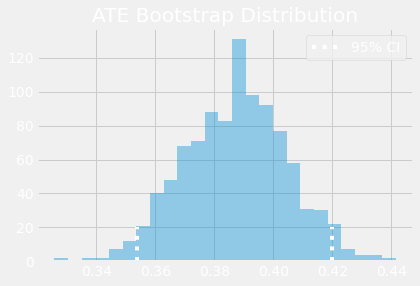

In [9]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

이제 doubly robust estimator 맛을 봤으니 이게 왜 대단한지 보죠. 먼저, $\hat{P}(x)$ 또는 $\hat{\mu}(x)$ 중 하나만 잘 추정한다면 잘 작동하기 때문에 doubly robust 하다고 부릅니다. $E[Y_1]$ 를 추정하는 첫번째 항을 가지고 살펴보도록 하겠습니다. 

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$\hat{\mu_1}(x)$ 이 정확하게 추정되었다고 가정해봅시다. 경향 점수 모델이 틀렸다고 해도 걱정할 필요없습니다. 왜냐하면 $\hat{\mu_1}(x)$ 정확하다면 $E[T_i(Y_i - \hat{\mu_1}(X_i))]=0$ 입니다. $T_i$ 가 곱해져서 처치된 값들만 선택하고 $\hat{\mu_1}$ 과의 잔차는 정의상 $0$이 됩니다. 그렇게 되면 추정량은 $\hat{\mu_1}(X_i)$ 에만 의존하게 되는데 가정에 의해 $\hat{\mu_1}(X_i)$ 은 $E[Y_1]$ 을 정확하게 추정하고 있습니다. 따라서, 교정에 의해 $\hat{\mu_1}(X_i)$ 경향 점수 모델을 싹 지워버립니다. 같은 방식으로 $E[Y_0]$ 의 추정량도 이해할 수 있습니다. 

글이 아니라 코드를 통해서 보여드릴게요! 다음 추정량에서는 경향 점수를 추정하는 로지스틱 회귀분석을 $0.1$ 에서 $0.9$ 의 값을 갖는 무작위 균일분포의 난수로 대체합니다 (아주 작은 가중치를 줘서 경향 점수 변동이 없어지지 않도록 합니다). 이 난수들은 무작위이기 때문에 경향 점수 모델은 절대 좋다고 할 수 없습니다. 하지만 doubly robust estimator는 여전히 로지스틱 모형으로 경향 점수를 추정했을 때와 매우 유사한 추정치를 갖습니다.


In [10]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [11]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

0.3796984428841887

Bootstrap 방법을 사용한다면 로지스틱 방법보다 추정치의 분산이 약간 큰 것을 알 수 있습니다.

In [12]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                              for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

In [13]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

print(f"Wrong PS ATE 95% CI:", (np.percentile(wrong_ps, 2.5), np.percentile(wrong_ps, 97.5)))

Original ATE 95% CI: (0.35365379802081925, 0.41978432347111305)
Wrong PS ATE 95% CI: (0.3386340898920725, 0.4330454015305953)


앞에서 보셨다시피 경향 점수를 망가뜨려서 약간 다르지만 큰 차이는 아닌 ATE 값들이 나왔습니다. 이 경우는 경향 점수가 잘못되고 평균 추정이 정확했습니다. 다른 상황에서는 어떨까요? 
첫번째 항을 다시 살펴보고 항들의 순서를 바꾸어보겠습니다. 

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i}{\hat{P}(X_i)} - 1\bigg) \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)
$

이제 경향 점수 $\hat{P}(X_i)$ 가 정확하다고 가정해봅시다. 이 경우에는 $E[T_i - \hat{P}(X_i)]=0$ 가 돼서 $\hat{\mu_1}(X_i)$ 와 관련된 항들을 지워버립니다. 이것이 doubly robust estimator 가 가정에 의해서 정확한 경향 점수 가중치 추정량 $\frac{T_iY_i}{\hat{P}(X_i)}$ 에만 의존하도록 만듭니다. 따라서 $\hat{\mu_1}(X_i)$ 가 틀렸다고 하더라도 경향 점수가 정확하기 때문에 추정량은 정확하게 됩니다. 

만약 수식보다 코드를 더 믿는다면 여기서 실제로 보이겠습니다. 아래 코드에서 회귀분석모델을 정규분포난수로 대체합니다. 여지 없이 $\hat{\mu}(X_i)$ 는 **틀렸습니다**. 그러나 여전히 doubly robust estimation는 앞서 본 약 0.38과 같은 $\hat{ATE}$ 를 보입니다. 

In [14]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [15]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

0.3981405305433191

또 bootstrap을 통해 추정치의 분산은 약간 높아지는 것을 확인할 수 있었습니다.

In [16]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                               for _ in range(bootstrap_sample))
wrong_mux = np.array(wrong_mux)

In [17]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))
print(f"Wrong Mu ATE 95% CI:", (np.percentile(wrong_mux, 2.5), np.percentile(ates, 97.5)))

Original ATE 95% CI: (0.35365379802081925, 0.41978432347111305)
Wrong Mu ATE 95% CI: (0.3387086426185005, 0.41978432347111305)


다시 한번 말하면 조건부 기댓값 모델만 망가뜨렸을 때 약간 다른 ATE 값이 나왔습니다. 나는 doubly robust estimation의 강력함을 저자들에게 확신시켰다고 생각합니다. 인과추론에서 doubly robust estimation의 마법은 일어납니다. 왜냐하면 인과 추정치의 편향을 없애기 위해 두 가지 방법이 있기 때문입니다. 하나는 처치 방식을 잘 모델링하는 것이고 다른 하나는 종속변수를 잘 모델링하는 것입니다. 만약 둘 중에 하나가 정확하다면 진행해도 좋습니다.

실제로 사용할 때 한 가지 주의할 점은 실제로 둘 중에 하나를 정화하게 모델링하는 것은 매우 어렵다는 것입니다. 실제로 경향 점수나 종속변수 모델링이 100% 정확하지 않는 경우가 결국에는 더 많습니다. 둘 다 다양한 방식으로 틀리게 됩니다. 이렇게 되면 단일 모델이 나을지 doubly robust estimation이 나을지 정확하게 알 수 없습니다 [\[1\]](https://www.stat.cmu.edu/~ryantibs/journalclub/kang_2007.pdf) [\[2\]](https://arxiv.org/pdf/0804.2969.pdf) [\[3\]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2798744/). 저같은 경우에 적어도 정확할 수 있는 두 개의 가능성이 있기 때문에 둘 다 사용합니다. 

## Key Ideas

이 장에서는 doubly robust estimator 를 만드는 선형회귀와 경향 점수를 결합하는 방식을 보았습니다. 이 추정량은 하나의 모델만 정확한 것을 요구하기 때문에 그런 이름이 붙었습니다. 만약 경향 점수 모델이 맞다면 종속변수 모델이 틀렸더라도 우리는 인과 효과를 추정할 수 있습니다. 반대로 종속변수 모델이 맞다면 경향 점수 모델이 틀리더라도 인과 효과를 추정할 수 있습니다. 

## References

저는 이 책을 Joshua Angrist, Alberto Abadie 및 Christopher Walters의 대단한 계량 경제학 수업에 대한 찬사라고 생각하고 싶습니다. 이 자료에 있는 대부분의 아이디어는 전미경제학회(American Economic Association)의 수업에서 가져왔어요. 이렇게 좋은 참고자료를 지켜보는 것이 저의 2020년의 힘든 한 해 동안, 온전한 정신을 유지하도록 도와주었어요.

* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)


또한 Angrist의 정말 좋은 책들을 참고자료 목록에 담고 싶습니다. 이 책들은 계량경제학(Econometrics) 또는 '메트릭스(Metrics, 계량적 분석)'가 매우 유용할 뿐만 아니라 매우 재미있다는 것을 저에게 보여주었습니다.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

마지막으로 제가 참고한 자료는 Miguel Hernan과 Jamie Robins의 책입니다. 이 책들은 제가 대답해야 했던 까다로운 인과적인 질문에서 신뢰할 수 있는 동반자와 같은 존재였어요.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

이 글에 쓰인 데이터는 Susan Athey과 Stefan Wager 이 [Estimating Treatment Effects with Causal Forests: An Application](https://arxiv.org/pdf/1902.07409.pdf) 제공하고 있습니다.

## Contribute

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 지적으로 접근이 가능할 수 있도록 하는 것이 목표입니다. 그리고, 이 책은 Python 기반의 무료 소프트웨어만 사용해요.
여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요. 
만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/matheusfacure/python-causality-handbook/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, [이 책의 Github 자료에 star](https://github.com/matheusfacure/python-causality-handbook/stargazers) 부탁드립니다!